# Data Modeling

_Model Appxor's dataset with Facebook's Prophet and **predict the event counts for each of the events in the dataset**._

<font color='red'>(This notebook is meant to be a proof of concept - the project definitely has scope for improvement with parameter tuning on the model and data engineering.)</font>

## Imports

In [2]:
import csv
import numpy as np
import time
import datetime
from fbprophet import Prophet
import pandas as pd
import pickle

## Utilities

### Save and Load Objects

In [2]:
def save_obj(obj, loc):
    with open(loc, 'wb') as out:
        pickle.dump(obj, out)

def load_obj(loc):
    with open(loc, 'rb') as inp:
        return pickle.load(inp)

## Data Processing

In [3]:
with open('data/hackthon.csv', 'r') as f:
    lines = []
    for line in csv.reader(f):
        lines.append(line)
print("Headers:", dict(zip(range(len(lines[0])), lines[0])))
print("Event types:", set([x[4] for x in lines[1:]]))

Headers: {0: 'hour', 1: 'date', 2: 'users', 3: 'event_count', 4: 'event_name', 5: 'day'}
Event types: {'bBCA', 'aS', 'nO', 'aO', 'sD', 'cFE', 'fL', 'nR', 'bBCD', 'bST'}


In [4]:
def reformat_time(h, d):
    # OUTPUT: YYYY-MM-DD HH:MM:SS
    return datetime.datetime.strptime(h+' '+d, "%H %Y-%m-%d")

def get_selection(event):
    selection = []
    for line in lines:
        if line[4] == event:
            selection.append(line)
    return(selection)

def gen_data_frame(selection):
    ds = [reformat_time(s[0], s[1]) for s in selection]
    y = [int(s[3]) for s in selection]
    return pd.DataFrame(zip(ds, y), columns=['ds', 'y'])

## Training

As an example, we train a model for the event named **_fL_**;

In [5]:
df = gen_data_frame(get_selection('fL'))
print("Total Data Points:", len(df))

# save input data frame
save_obj(df, 'data/observations_fL.pkl')

Total Data Points: 19910


In [30]:
m = Prophet(interval_width=0.95, yearly_seasonality=True, 
            weekly_seasonality=True, changepoint_prior_scale=2)
m.add_seasonality(name='monthly', period=30.5, 
                  fourier_order=5, prior_scale=0.2)

m.fit(df)

## Forecasting

In [38]:
# make dataframe of current timeline 
# with 10000 additional hour-units into the future
future = m.make_future_dataframe(periods=2000, freq='H')

# get predictions
fcst = m.predict(future)

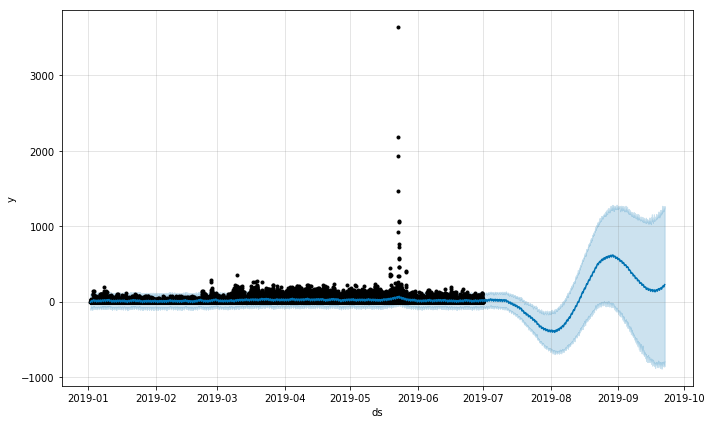

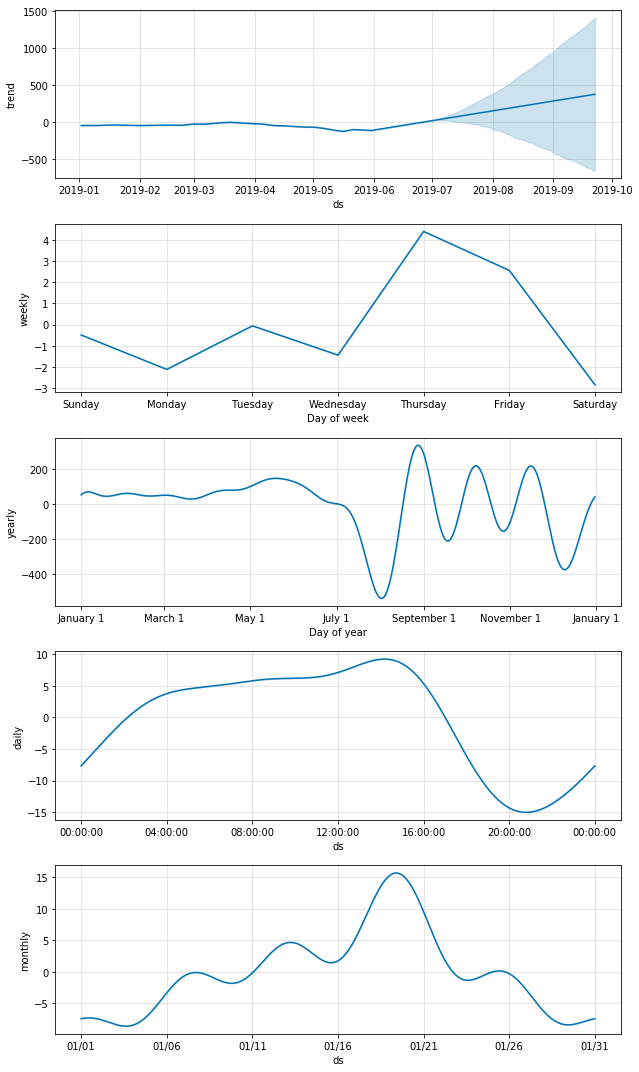

In [40]:
# plot predictions
fig1 = m.plot(fcst)
fig2 = m.plot_components(fcst)

## Save Model and Forecast

In [41]:
save_obj(m, 'data/model_fL.pkl')
save_obj(fcst, 'data/predections_fL_2000.pkl')

## Summary

This trained model can be stored to forecast data again, and also to serve as the base for the next iteration of a continuously training model - we produce the forecasts for a fixed time period, then retrain the model on the _real_ data produced in that period of time.

The saved forecast can be converted to JSON and sent to the client for real-time comparisons between predicted data and real data, as highly intuitive visualizations.

All computation except for the visualizations themselves, take place on the server.